# Using PaliGemma with 🤗 transformers

PaliGemma is a new vision language model released by Google. In this notebook, we will see how to use 🤗 transformers for PaliGemma inference.
First, install below libraries with update flag as we need to use the latest version of 🤗 transformers along with others.

PaliGemma requires users to accept Gemma license, so make sure to go to [the repository]() and ask for access. If you have previously accepted Gemma license, you will have access to this model as well. Once you have the access, login to Hugging Face Hub using `notebook_login()` and pass your access token by running the cell below.

In [1]:
from huggingface_hub import notebook_login

notebook_login()

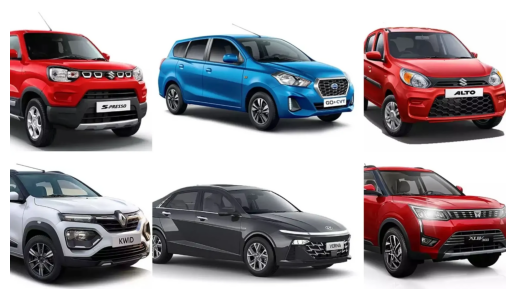

In [2]:
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

input_text = "How many cars are in the image"
img_url = "https://northfleet.in/wp-content/uploads/2023/12/Best-Family-Cars-in-India-2048x1152.webp"
input_image = Image.open(requests.get(img_url, stream=True).raw)
plt.imshow(input_image)
plt.axis('off')
plt.show()

We can pass in our preprocessed inputs.

## Load model in 4-bit

You can also load model in 4-bit and 8-bit, which offers memory gains during inference.
First, initialize the `BitsAndBytesConfig`.

You can load PaliGemma model and processor like below.

In [3]:
from transformers import BitsAndBytesConfig
import torch
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)


We will now reload the model but pass in above object as `quantization_config`.

In [4]:
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch

device="cuda"
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16,
                                                          quantization_config=nf4_config, device_map={"":0})
processor = PaliGemmaProcessor.from_pretrained(model_id)

/home/prakhar/Desktop/Tata Competition/Tata_Innovent_2024/Tata/lib64/python3.12/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2024-09-27 01:00:11.743770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 01:00:11.825919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 01:00:11.843709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 01:00:11.942591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 01:00:13.288986: W tensorflow/compiler/tf2

The processor preprocesses both the image and text, so we will pass them.

In [5]:
inputs = processor(text=input_text, images=input_image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt")
inputs = inputs.to(dtype=model.dtype)


In [6]:
with torch.no_grad():
  output = model.generate(**inputs, max_length=496)

print(processor.decode(output[0], skip_special_tokens=True))

/home/prakhar/Desktop/Tata Competition/Tata_Innovent_2024/Tata/lib64/python3.12/site-packages/transformers/generation/utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


How many cars are in the image
6
